In [1]:
!pip install sentencepiece
!pip install tf_sentencepiece

     |████████████████████████████████| 1.0MB 8.7MB/s 
     |████████████████████████████████| 2.7MB 9.1MB/s 


In [2]:
!pip install fastai==1.0.52

     |████████████████████████████████| 225kB 9.6MB/s 
  Found existing installation: fastai 1.0.57
    Uninstalling fastai-1.0.57:
      Successfully uninstalled fastai-1.0.57


In [0]:
from fastai import *
from fastai.text import *

import re
import sentencepiece as spm

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
subsets=aa/'subsets'

In [0]:
vocab_size = 30000
model_prefix = 'sp'

In [7]:
#Head of the Vocab file: Line nums indicate index of vocab
!head -n10 {model_prefix}.vocab | nl

     1	<unk>	0
     2	<s>	0
     3	</s>	0
     4	▁	-1.92809
     5	।	-3.08075
     6	,	-3.75831
     7	"	-3.82833
     8	▁"	-4.22803
     9	▁ও	-4.91756
    10	র	-4.94756


In [8]:
## load up the Processor
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

True

In [0]:
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])

In [10]:
len(itos)

30000

In [11]:
itos[:5], itos[-5:]

(['<unk>', '<s>', '</s>', '▁', '।'],
 ['ইমরুল', '▁কামরাঙ্গীর', '▁whe', '▁অভ্যন্তরী', '/'])

In [0]:
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [0]:
#setup Vocab object for use in LM
sp_vocab = Vocab(itos)

In [0]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix)

In [0]:
bs = 32
bptt = 70

In [0]:
data_lm = load_data(news, 'news_subword.pkl',bs=bs)

In [0]:
import matplotlib.pyplot as plt

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


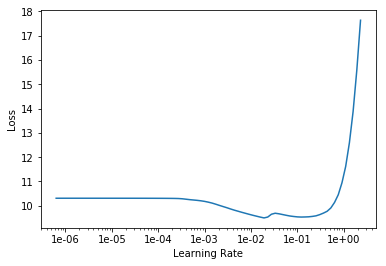

In [0]:
learn.lr_find();
learn.recorder.plot();
plt.savefig('clr_sub.eps')

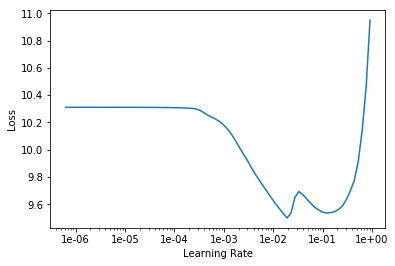

In [0]:
learn.recorder.plot(skip_end=10)
plt.savefig('clr_sub_skipend.eps')

## Our AA

#### Our AA (LM)

In [0]:
data_lm_AA = TextLMDataBunch.from_csv(aa , 'OurDataset_train.csv', bs=bs , bptt=bptt,tokenizer=mycust_tok, vocab=sp_vocab)
data_lm_AA.save('train_AA_subword_lm.pkl')

In [0]:
data_lm_AA = load_data(aa, 'train_AA_subword_lm.pkl',bs=bs)

In [0]:
data_lm_AA.show_batch()

idx,text
0,▁ র টা ইয়া ▁তাহার ▁জনপ্রিয়তা কে ▁আঘাত ▁করি বার ▁চেষ্টা ▁করি লে ▁কেমন ▁হয় ? ▁তিনি ▁তাহার ▁নায়েব কেও ▁তৎক্ষণাৎ ▁পাল্টা ▁একটা ▁ডায়রি ▁করি তে ▁থানায় ▁পাঠাই লেন ▁এবং ▁মিথ্যা ▁কথাটা ▁ ই র সাদ - র হম ের ▁কানে ▁তুলি তে ▁বল িয়া ▁দিলেন । ▁উত্তেজনা য় ▁অধীর ▁জনতা ▁সঙ্গে ▁সঙ্গে ▁কথাটা ▁বিশ্বাস ▁করিয়া ▁ ল ইল । ▁ র হম - ই র সা দের ▁প্রথম টা
1,▁তারপর ? ▁বাসায় ▁ফিরে ▁শোবার ▁ঘরে ▁ঢুকে ▁দেখি ▁বিছানা র ▁উপর ▁সেই ▁সু ট কে স টা ▁পড়ে ▁আছে — ▁কয়েকটা ▁চাবি ▁দিয়ে ▁সু ট কে স টা ▁খোল বার ▁চেষ্টা ▁করলাম । ▁কিন্তু ▁কোন ▁চাবি র ▁সাহায্যে ই ▁সু ট কে স টা ▁খুলতে ▁পারলাম ▁না । ▁আপনি ▁সু ট কে স টা ▁খুলতে ▁চেষ্টা ▁করেছিলেন ▁তাহলে ? ▁হ্যাঁ । ▁তারপর ? ▁কেমন ▁যেন ▁একটা ▁ভয় ▁ভূতের ▁মত ▁আমাকে
2,"▁করে ▁বই ▁বন্ধ ▁করে ▁রাগে ▁ ফো ঁস ফো ঁস ▁করতে ▁করতে ▁বলল – বল ▁ কাহ নের ▁অর্থ ▁কী ▁আমাকে ▁বল । ▁অর্থ ▁জেনে ▁তারপর ▁পড়ব । ▁আমি ▁তোমার ▁শাশুড়ি র ▁ভাব ভঙ্গি ▁দেখে ▁একটু ▁ টেনশন ে ▁পড়ে ▁গেলাম । ▁তার ▁নেচার তো ▁জানি । ▁লোকজন ▁তিল কে ▁তাল ▁করে । ▁তোমার ▁শাশুড়ি ▁তিল কে ▁বড় ▁সাই জের ▁ক ঁ ঠা ল ▁করে । ▁ভালো ▁কথা ▁মা ,"
3,"▁না ? ▁সামান্য ▁সেন্ট ি মেন্ট ? ▁ফোন টা ▁আবার ▁তুলে ▁নিল ▁হেমা ঙ্গ । ▁চারু দি , ▁কেমন ▁আছি স ? ▁কেমন ▁আছি ? ▁তা ▁দিয়ে ▁তোর ▁কি ▁দরকার ? ▁আমাদের ▁থাকা ▁বা ▁না - থাকা য় ▁তোর ▁কী ▁আসে ▁যায় ? ▁আমার ▁খোঁজ ▁করেছিল ি ▁কেন ? ▁চারু শীল া ▁একটু ▁চুপ ▁করে ▁থেকে ▁বলল , ▁এখন ▁আটটা ▁বাজে । ▁আসতে ▁পারব ি ? ▁ টা য়ার্ড ▁লাগছে"
4,", ▁মা ▁বললেন – খা ড় ইয়া ▁পানি ▁খাস ▁ক্যান ? ▁ খা ড় ইয়া ▁পানি ▁খাই লে ▁ শয়তান ের ▁মু ত ▁খাওয়া ▁হয় । ▁পেশা ব খানা ▁থেকে ▁এলে ▁হাত ▁পরীক্ষা ▁করেন ▁ভেজা ▁কি ▁না , ▁না ▁ভেজা ▁থাকলে – মু ই তা ▁পানি ▁ ল ই ছ স ? ▁হিন্দু রা ▁মু ই তা ▁পানি ▁ লয় ▁না । ▁ কাফ ের ের ▁একমাত্র ▁স্থান ▁দো য"


In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(news/'models'/'news_subword_lm_31');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


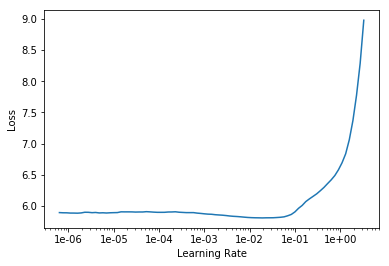

In [0]:
learn.lr_find();
learn.recorder.plot();
plt.savefig('clr_sub_lmAA.eps')

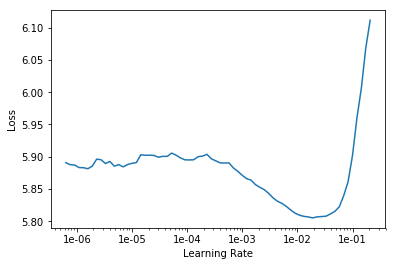

In [0]:
learn.recorder.plot(skip_end=20);
plt.savefig('clr_sub_lmAA_skipend.eps')

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_subword_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,5.033468,4.924835,0.220223,37:06
1,4.988395,4.863129,0.225376,37:07


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_subword_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,4.775554,4.658215,0.246022,37:49
1,4.723702,4.584692,0.254028,37:51


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_subword_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,4.596820,4.472740,0.266224,40:35
1,4.426194,4.385971,0.276817,40:33


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_subword_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,4.450388,4.365835,0.278578,42:11
1,4.298214,4.292197,0.287136,42:08


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_subword_lm_body_4')

epoch,train_loss,valid_loss,accuracy,time
0,4.368409,4.299394,0.285895,42:33
1,4.213906,4.236476,0.293529,42:46


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_subword_lm_body_5')

epoch,train_loss,valid_loss,accuracy,time
0,4.241201,4.256907,0.290587,42:38
1,4.162889,4.199232,0.297537,42:44


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_subword_lm_body_6')

epoch,train_loss,valid_loss,accuracy,time
0,4.167974,4.226469,0.293712,42:37
1,4.079694,4.172688,0.300717,42:24


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_subword_lm_body_7')

epoch,train_loss,valid_loss,accuracy,time
0,4.221254,4.203250,0.296642,42:09
1,4.136843,4.151529,0.303101,42:13


In [0]:
learn.load('AA_subword_lm_body_7')
learn.fit_one_cycle(2, 1e-4) ### becuase oscillations started
learn.save('AA_subword_lm_body_8')

epoch,train_loss,valid_loss,accuracy,time
0,4.059014,4.146458,0.303633,45:25
1,4.047419,4.143106,0.303997,45:27


In [18]:
learn.load('AA_subword_lm_body_8')
learn.fit_one_cycle(2, 1e-4) ### see if loss reduces, else thats all!
learn.save('AA_subword_lm_body_9')

epoch,train_loss,valid_loss,accuracy,time
0,4.012450,4.140856,0.304243,22:18
1,3.977485,4.138100,0.304580,22:19


In [19]:
learn.fit_one_cycle(2, 1e-4)
learn.save('AA_subword_lm_body_10')

epoch,train_loss,valid_loss,accuracy,time
0,3.984483,4.136797,0.304558,22:19
1,3.984481,4.134292,0.304957,22:19


In [0]:
learn.load('AA_subword_lm_body_10');

In [0]:
learn.save_encoder('AA_subword_lm_enc')

#### Classifier (our AA)

In [0]:
data_clas = TextClasDataBunch.from_csv(aa , 'OurDataset_train.csv', tokenizer=mycust_tok, vocab=sp_vocab, bs=bs)
data_clas.save('AA_subword_clas.pkl')

In [0]:
data_clas = load_data(aa, 'AA_subword_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('AA_subword_lm_enc')

In [23]:
data_clas.show_batch()

text,target
"▁xx b os ▁সপ্তম ▁রাত ্রে ▁মনে ▁করি ল , ▁হৃদয় মধ্যে ▁পদ্ম ফুল ▁ফুট িয়া ছে — তাহা তে ▁চন্দ্র শেখ র ▁যোগ াসন ে ▁ব সিয়া ▁আছেন ; ▁শ ৈ বল িনী ▁ ভ্রম র ▁হইয়া ▁ পাদ পদ্ম ে ▁গুণ গুণ ▁করি তে ছে । ▁তৃতীয় ▁পরি চ্ছেদ ▁ : ▁বাতাস ▁উঠি ল ▁শ ৈ বল িনী ▁তা হাই ▁করি ল — স প্ত দিবস ▁গুহা ▁হইতে",bongkim
"▁xx b os ▁চা হিয়া ▁ র হি লেন – মুখে ▁মনুষ্য ের ▁ সাধ্য াতীত ▁রোগের ▁ছায়া । ▁ মাধব ী নাথ ▁তা ঁ হার ▁সঙ্গে ▁কথা ▁ক হি লেন ▁না – মাধব ী নাথ ▁মনে ▁মনে ▁প্রতিজ্ঞা ▁করিয়া ছিলেন ▁যে , ▁ইহ জন্ম ে ▁আর ▁গোবিন্দ লাল ের ▁সঙ্গে ▁কথা ▁ক হি বেন ▁না । ▁বিনা বাক্য ে ▁ মাধব ী নাথ ▁চল িয়া ▁গেলেন । ▁গোবিন্দ লাল",bongkim
"▁xx b os ▁স্থাপিত ▁হই ল । ▁শ ৈ বল িনী ▁ তাহা ▁পরি ধান ▁করিয়া , ▁পূর্ব বস্ত্র ▁পরিত্যাগ ▁করিয়া ▁জিজ্ঞাসা ▁করি ল , ▁“ আর ▁কি ▁করি ব ?” ▁উত্তর — তোমার ▁শ্বশুর ালয় ▁কোথায় ? ▁শ ৈ । ▁ বেদ গ্রাম । ▁সেখানে ▁কি ▁যাই তে ▁হইবে ? ▁উত্তর — হাঁ — গ িয়া ▁গ্রাম প্রান্ত ে ▁প র্ণ কুট ীর ▁নির্মাণ ▁করি বে । ▁শ ৈ",bongkim
"▁xx b os ▁গভীর া । ▁এখনও ▁যে ▁তা ঁ হা কে ▁ব্যা ঘ ্রে ▁হত্যা ▁করে ▁নাই , ▁ ই হা ▁তা ঁ হার ▁আশ্চর্য ্য ▁বোধ ▁হই ল । ▁ইতস্তত ঃ ▁নিরীক্ষ ণ ▁করিয়া ▁দেখি তে ▁লা গি লেন , ▁ব্যা ঘ ্র ▁আসি তে ছে ▁কি ▁না । ▁ অক স্ মা ৎ ▁সম্মুখ ে ▁বহু ▁দূরে , ▁একটা ▁আলোক ▁দেখি তে ▁পাই লেন । ▁ পাছে",bongkim
"▁xx b os ▁রাজপুত ▁কোথাও ▁লুকা ইয়া ▁আছে ▁কি ▁না । ▁অতএব ▁বিক্রম ▁সোল াঙ্ক ির ▁অ শ্ বার ো হি গণ ের ▁সন্ধান , ▁তা ঁ হা কে ▁সহজে ▁মিল িল । ▁তিনি ▁তখন ▁কত ক গুলি ▁সৈন্য ▁অ শ্ বার ো হি দিগ কে ▁তাড়া ইয়া ▁দিবা র ▁জন্য ▁পাঠ াইয়া ▁দিলেন । ▁বিক্রম ▁সোল াঙ্ক ি ▁অন্যান্য ▁বিষয়ে ▁বড় ▁স্থূল বুদ্ধি , ▁কিন্তু ▁যুদ্ধ কালে ▁অতিশয় ▁",bongkim


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


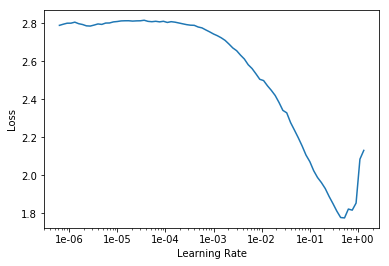

In [25]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [26]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('subword_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.096239,0.026681,0.994087,07:33
1,0.047045,0.017862,0.994435,07:37


In [27]:
learn_cls.load('subword_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('subword_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.089726,0.020861,0.993391,08:30
1,0.029179,0.011343,0.995826,08:26


In [28]:
learn_cls.load('subword_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('subword_cls_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.051422,0.017930,0.994087,12:02
1,0.014178,0.008877,0.997217,12:09


In [29]:
learn_cls.load('subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.011757,0.008527,0.997565,14:47
1,0.010883,0.006695,0.997913,14:56


In [30]:
learn_cls.load('subword_cls_4')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('subword_cls_5')

epoch,train_loss,valid_loss,accuracy,time
0,0.009015,0.008236,0.996870,15:06
1,0.006162,0.005400,0.998261,14:46


In [31]:
learn_cls.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('subword_cls_6')

epoch,train_loss,valid_loss,accuracy,time
0,0.005907,0.008098,0.998261,15:03
1,0.006098,0.006475,0.998261,15:01


**loss increased in 6, so we use 5**

In [0]:
learn_cls.load('subword_cls_5');

In [0]:
def testing(dts):
  df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = learn_cls.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  print("Accuracy: ")
  print(count/tst)
  print(err)
  return final_preds, targets

In [35]:
pred,targ = testing(aa/'OurDataset_test.csv')

3592
Accuracy: 
0.9980512249443207
[('humayun_ahmed', 'MZI'), ('manik_bandhopaddhay', 'shirshendu'), ('nihar_ronjon_gupta', 'shottojit_roy'), ('shorotchandra', 'robindronath'), ('zahir_rayhan', 'shomresh'), ('shordindu', 'bongkim'), ('shordindu', 'bongkim')]


In [36]:
from sklearn.metrics import f1_score
out  = f1_score(targ, pred, average='weighted')
out

0.9980499459498295

In [37]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(targ, pred)
print(cm)

[[220   0   0   0 ...   0   0   0   0]
 [  0 112   0   0 ...   0   0   0   0]
 [  1   0 905   0 ...   0   0   0   0]
 [  0   0   0  92 ...   0   0   0   0]
 ...
 [  0   0   0   0 ... 393   0   0   0]
 [  0   0   0   0 ...   0 155   0   0]
 [  0   0   0   0 ...   0   0 186   0]
 [  0   0   0   0 ...   0   0   0  36]]


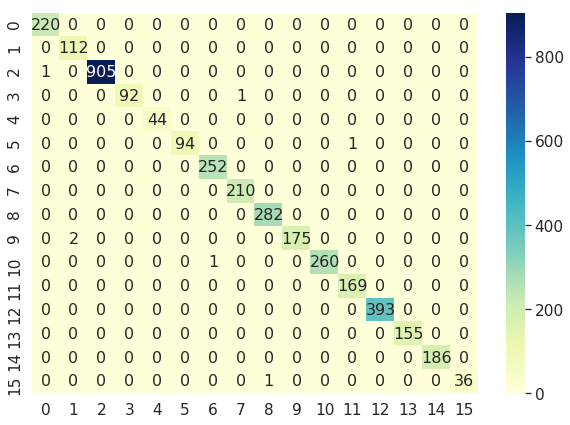

In [38]:
import seaborn as sn

df_cm = pd.DataFrame(cm, range(16),range(16))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap="YlGnBu")# font size

import matplotlib.pyplot as plt
plt.savefig('news_subword_AA.eps')

In [0]:
from google.colab import files
files.download('news_subword_AA.eps')